In [1]:
import sys
sys.path.append("..") #Parent 
sys.path.append("../..") #grandparent
import torch
from models.components.ldm.denoiser import UNetModel
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import json
import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import json
import matplotlib.colors as mcolors
import seaborn as sns


In [2]:
from models.components.unet import DownscalingUnetLightning 
from models.ae_module import AutoencoderKL
from models.components.ae import SimpleConvEncoder, SimpleConvDecoder
from models.components.ldm.denoiser.ddim import DDIMSampler
from models.ldm_module import LatentDiffusion
from DownscalingDataModule import DownscalingDataModule

Instantiating UNet

In [3]:
ckpt_unet = "trained_ckpts/Training_LDM.models.components.unet.DownscalingUnetLightning_checkpoint.ckpt"


In [4]:

model_UNet = DownscalingUnetLightning(
    in_ch=5,  # 4 vars + elevation
    out_ch=4,  # 4 output variables
    features=[64, 128, 256, 512],
    channel_names=["precip", "temp", "temp_min", "temp_max"]
)

In [5]:
unet_state_dict = torch.load(ckpt_unet, map_location="cpu")["state_dict"]
model_UNet.load_state_dict(unet_state_dict, strict=False)
model_UNet.eval()

DownscalingUnetLightning(
  (unet): DownscalingUnet(
    (e1): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (e2): EncoderBlock(
      (conv): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3,

Instantiating VAE for residual encoding 

In [6]:
ckpt_vae = "trained_ckpts/Training_LDM.models.ae_module.AutoencoderKL_checkpoint.ckpt"

In [7]:
# Debug: Load checkpoint to see the original configuration
checkpoint = torch.load(ckpt_vae, map_location="cpu")

In [9]:
encoder = SimpleConvEncoder(in_dim=4, levels=1, min_ch=64, ch_mult=1)
decoder = SimpleConvDecoder(in_dim=64, levels=1, min_ch=16)  # Changed from levels=2 to levels=1
model_VAE = AutoencoderKL.load_from_checkpoint(
    ckpt_vae,
    encoder=encoder,
    decoder=decoder,
    kl_weight=0.01,
    strict=False 
)
model_VAE.eval()

AutoencoderKL(
  (encoder): SimpleConvEncoder(
    (net): Sequential(
      (0): ResBlock2D(
        (proj): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act1): SiLU()
        (act2): SiLU()
        (norm1): GroupNorm(1, 4, eps=1e-05, affine=True)
        (norm2): GroupNorm(1, 64, eps=1e-05, affine=True)
        (sequence): Sequential(
          (0): GroupNorm(1, 4, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): GroupNorm(1, 64, eps=1e-05, affine=True)
          (4): SiLU()
          (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (1): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (decoder): SimpleConvDecoder(
    (net): Sequential(
      (0): ConvTranspose

Latent denoising 

For denoisign in latent space 

In [10]:
ckpt_ldm = "trained_ckpts/LDM_checkpoint.ckpt"

remapping of keys for overcoming the error 

In [11]:
ldm_ckpt = torch.load(ckpt_ldm, map_location="cpu")
remapped_ldm_state_dict = {}
for k, v in ldm_ckpt["state_dict"].items():
    if k.startswith("autoencoder.unet_regr.unet."):
        new_key = "autoencoder.unet." + k[len("autoencoder.unet_regr.unet."):]
    elif k.startswith("autoencoder.unet_regr."):
        new_key = "autoencoder.unet." + k[len("autoencoder.unet_regr."):]
    else:
        new_key = k
    remapped_ldm_state_dict[new_key] = v


In [12]:
denoiser=UNetModel(in_channels=32,
  out_channels=32,
  model_channels=64,
  num_res_blocks=2,
  attention_resolutions=[1,2,4],
  context_ch=None,  # [128,128,128,128] #Changed to null for a first experiment (unconditional generation from latent space): AsthanaSh
  channel_mult=[1,2,4,4],
  conv_resample=True,
  dims=2,
  use_fp16=False,
  num_heads=4)

In [13]:
model_LDM=LatentDiffusion(denoiser=denoiser,
  autoencoder=model_VAE)

In [14]:
model_LDM.load_state_dict(remapped_ldm_state_dict, strict=False)
model_LDM.eval()

LatentDiffusion(
  (denoiser): UNetModel(
    (time_embed): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): SiLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (input_blocks): ModuleList(
      (0): TimestepEmbedSequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x TimestepEmbedSequential(
        (0): ResBlock(
          (in_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (emb_layers): Sequential(
            (0): SiLU()
            (1): Linear(in_features=256, out_features=64, bias=True)
          )
          (out_layers): Sequential(
            (0): Identity()
            (1): SiLU()
            (2): Dropout(p=0, inplace=False)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
      

#Inference goes from Unet----VAE----denosiing within VAE

In [15]:
def pipeline(input_sample, target_sample=None, seed=None):
    with torch.no_grad():
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        unet_prediction = model_UNet(input_sample)

        # Residuals for denoising
        if target_sample is not None:
            residuals = target_sample - unet_prediction

        # VAE encoding
        mean, log_var = model_VAE.encode(residuals)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        latent = mean + eps * std  # (1, 64, H', W')

        # Denoising
        sampler = DDIMSampler(model_LDM)
        shape = latent.shape[1:]

        denoised_latent, _ = sampler.sample(
            S=50,
            batch_size=1,
            shape=shape,
            x_T=latent,
            eta=0.5,
            verbose=False,
            progbar=True
        )

        # Decoding
        refined_residuals = model_VAE.decode(denoised_latent)  # (1, 4, H, W)

        # Unet plus refined residuals
        final_prediction = unet_prediction + refined_residuals

        return {
            'unet_prediction': unet_prediction,
            'original_residuals': residuals,
            'refined_residuals': refined_residuals,
            'final_prediction': final_prediction
        }


Datasets for dtaamodule

In [16]:
test_input_paths = {
    'precip': f'{config.DATASETS_TRAINING_DIR}/RhiresD_input_test_chronological_scaled.nc',
    'temp': f'{config.DATASETS_TRAINING_DIR}/TabsD_input_test_chronological_scaled.nc',
    'temp_min': f'{config.DATASETS_TRAINING_DIR}/TminD_input_test_chronological_scaled.nc',
    'temp_max': f'{config.DATASETS_TRAINING_DIR}/TmaxD_input_test_chronological_scaled.nc'
}

test_target_paths = {
    'precip': f'{config.DATASETS_TRAINING_DIR}/RhiresD_target_test_chronological_scaled.nc',
    'temp': f'{config.DATASETS_TRAINING_DIR}/TabsD_target_test_chronological_scaled.nc',
    'temp_min': f'{config.DATASETS_TRAINING_DIR}/TminD_target_test_chronological_scaled.nc',
    'temp_max': f'{config.DATASETS_TRAINING_DIR}/TmaxD_target_test_chronological_scaled.nc'
}

elevation_path = f'{config.BASE_DIR}/sasthana/Downscaling/Downscaling_Models/elevation.tif'

In [17]:
dm = DownscalingDataModule(
    train_input={},  # Empty for inference
    train_target={},  # Empty for inference
    test_input=test_input_paths,
    test_target=test_target_paths,
    elevation=elevation_path,
    batch_size=32,
    num_workers=4,
    preprocessing={
        'variables': {
            'input': {
                'precip': 'RhiresD',
                'temp': 'TabsD', 
                'temp_min': 'TminD',
                'temp_max': 'TmaxD'
            },
            'target': {
                'precip': 'RhiresD',
                'temp': 'TabsD',
                'temp_min': 'TminD', 
                'temp_max': 'TmaxD'
            }
        },
        'preprocessing': {
            'nan_to_num': True,
            'nan_value': 0.0
        }
    }
)

# Setup the data module
dm.setup('test')


In [18]:
test_loader = dm.test_dataloader()
test_batch = next(iter(test_loader))
test_inputs, test_targets = test_batch

idx = 5
input_sample = test_inputs[idx].unsqueeze(0)  # (1, 5, H, W)
target_sample = test_targets[idx].unsqueeze(0)  # (1, 4, H, W)
results_list = []
for i in range(3):
    results = pipeline(input_sample, target_sample, seed=i)
    results_list.append(results)

Data shape for DDIM sampling is (1, 32, 120, 185), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


Data shape for DDIM sampling is (1, 32, 120, 185), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Data shape for DDIM sampling is (1, 32, 120, 185), eta 0.5
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


In [20]:
for i, results in enumerate(results_list):
    final_np = results['final_prediction'][0].cpu().numpy()  # shape: (4, H, W)
    for j, name in enumerate(["Precip", "Temp", "Min Temp", "Max Temp"]):
        arr = final_np[j]
        print(f"Sample {i+1} {name}: min={np.nanmin(arr):.3f}, max={np.nanmax(arr):.3f}")

Sample 1 Precip: min=-0.218, max=2.402
Sample 1 Temp: min=-8.352, max=15.887
Sample 1 Min Temp: min=-18.016, max=9.464
Sample 1 Max Temp: min=-13.896, max=7.542
Sample 2 Precip: min=-0.249, max=2.401
Sample 2 Temp: min=-8.891, max=16.095
Sample 2 Min Temp: min=-17.690, max=9.372
Sample 2 Max Temp: min=-13.508, max=7.211
Sample 3 Precip: min=-0.210, max=2.393
Sample 3 Temp: min=-9.055, max=15.807
Sample 3 Min Temp: min=-18.173, max=9.335
Sample 3 Max Temp: min=-13.518, max=6.716


Denormalisation and plotting  : 


In [20]:
#Denorm function

In [21]:
with open(f'{config.DATASETS_TRAINING_DIR}/RhiresD_scaling_params_chronological.json', 'r') as f:
    pr_params = json.load(f)
with open(f'{config.DATASETS_TRAINING_DIR}/TabsD_scaling_params_chronological.json', 'r') as f:
    temp_params = json.load(f)
with open(f'{config.DATASETS_TRAINING_DIR}/TminD_scaling_params_chronological.json', 'r') as f:
    temp_min_params = json.load(f)
with open(f'{config.DATASETS_TRAINING_DIR}/TmaxD_scaling_params_chronological.json', 'r') as f:
    temp_max_params = json.load(f)

def denorm_pr(x):

    return x * (pr_params['max'] - pr_params['min']) + pr_params['min']

def denorm_temp(x, params):

    return x * params['std'] + params['mean']


denorm and plotting 

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
def denorm_plot_samples(results_list, input_sample, target_sample):
    input_np = input_sample[0, :4].cpu().numpy()
    target_np = target_sample[0].cpu().numpy()
    input_denorm = np.empty_like(input_np)
    target_denorm = np.empty_like(target_np)
    for i, (var, params) in enumerate([
        ("precip", pr_params),
        ("temp", temp_params), 
        ("temp_min", temp_min_params),
        ("temp_max", temp_max_params)
    ]):
        if var == "precip":
            input_denorm[i] = denorm_pr(input_np[i])
            target_denorm[i] = denorm_pr(target_np[i])
        else:
            input_denorm[i] = denorm_temp(input_np[i], params)
            target_denorm[i] = denorm_temp(target_np[i], params)

    # Mask: original NaN grid cells in input
    mask = np.any(np.isnan(input_np), axis=0)

    channel_names = ["Precip", "Temp", "Min Temp", "Max Temp"]
    n_vars = 4
    n_samples = len(results_list)
    n_rows = n_samples + 3

    fig, axes = plt.subplots(n_rows, n_vars, figsize=(5 * n_vars, 3.5 * n_rows), dpi=200)

    # Color normalization using percentiles for better contrast
    vmin = np.nanpercentile(target_denorm, 2)
    vmax = np.nanpercentile(target_denorm, 98)

    # Custom colormap: coolwarm with NaNs as black
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    cmap.set_bad(color='black')

    # Top row: Input
    for j in range(n_vars):
        arr = input_denorm[j].copy()
        arr[mask] = np.nan
        sns.heatmap(np.flipud(arr), ax=axes[0, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        axes[0, j].set_title(f"Input to UNet - {channel_names[j]}")
        axes[0, j].axis('off')

    # Second row: UNet Prediction
    unet_np = results_list[0]['unet_prediction'][0].cpu().numpy()
    for j in range(n_vars):
        if channel_names[j].lower().startswith("precip"):
            unet_denorm = denorm_pr(unet_np[j])
        else:
            params = [pr_params, temp_params, temp_min_params, temp_max_params][j]
            unet_denorm = denorm_temp(unet_np[j], params)
        arr = unet_denorm.copy()
        arr[mask] = np.nan
        sns.heatmap(np.flipud(arr), ax=axes[1, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        axes[1, j].set_title(f"UNet Prediction - {channel_names[j]}")
        axes[1, j].axis('off')

    # Middle rows: Samples
    for i, results in enumerate(results_list):
        final_np = results['final_prediction'][0].cpu().numpy()
        for j in range(n_vars):
            if channel_names[j].lower().startswith("precip"):
                sample_denorm = denorm_pr(final_np[j])
            else:
                params = [pr_params, temp_params, temp_min_params, temp_max_params][j]
                sample_denorm = denorm_temp(final_np[j], params)
            arr = sample_denorm.copy()
            arr[mask] = np.nan
            sns.heatmap(np.flipud(arr), ax=axes[i+2, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
            axes[i+2, j].set_title(f"Sample {i+1} - {channel_names[j]}")
            axes[i+2, j].axis('off')

    # Bottom row: Ground Truth
    for j in range(n_vars):
        arr = target_denorm[j].copy()
        arr[mask] = np.nan
        sns.heatmap(np.flipud(arr), ax=axes[-1, j], cmap=cmap, vmin=vmin, vmax=vmax, cbar=True, cbar_kws={'shrink': 0.7})
        axes[-1, j].set_title(f"Ground Truth - {channel_names[j]}")
        axes[-1, j].axis('off')

    plt.tight_layout()
    plt.show()

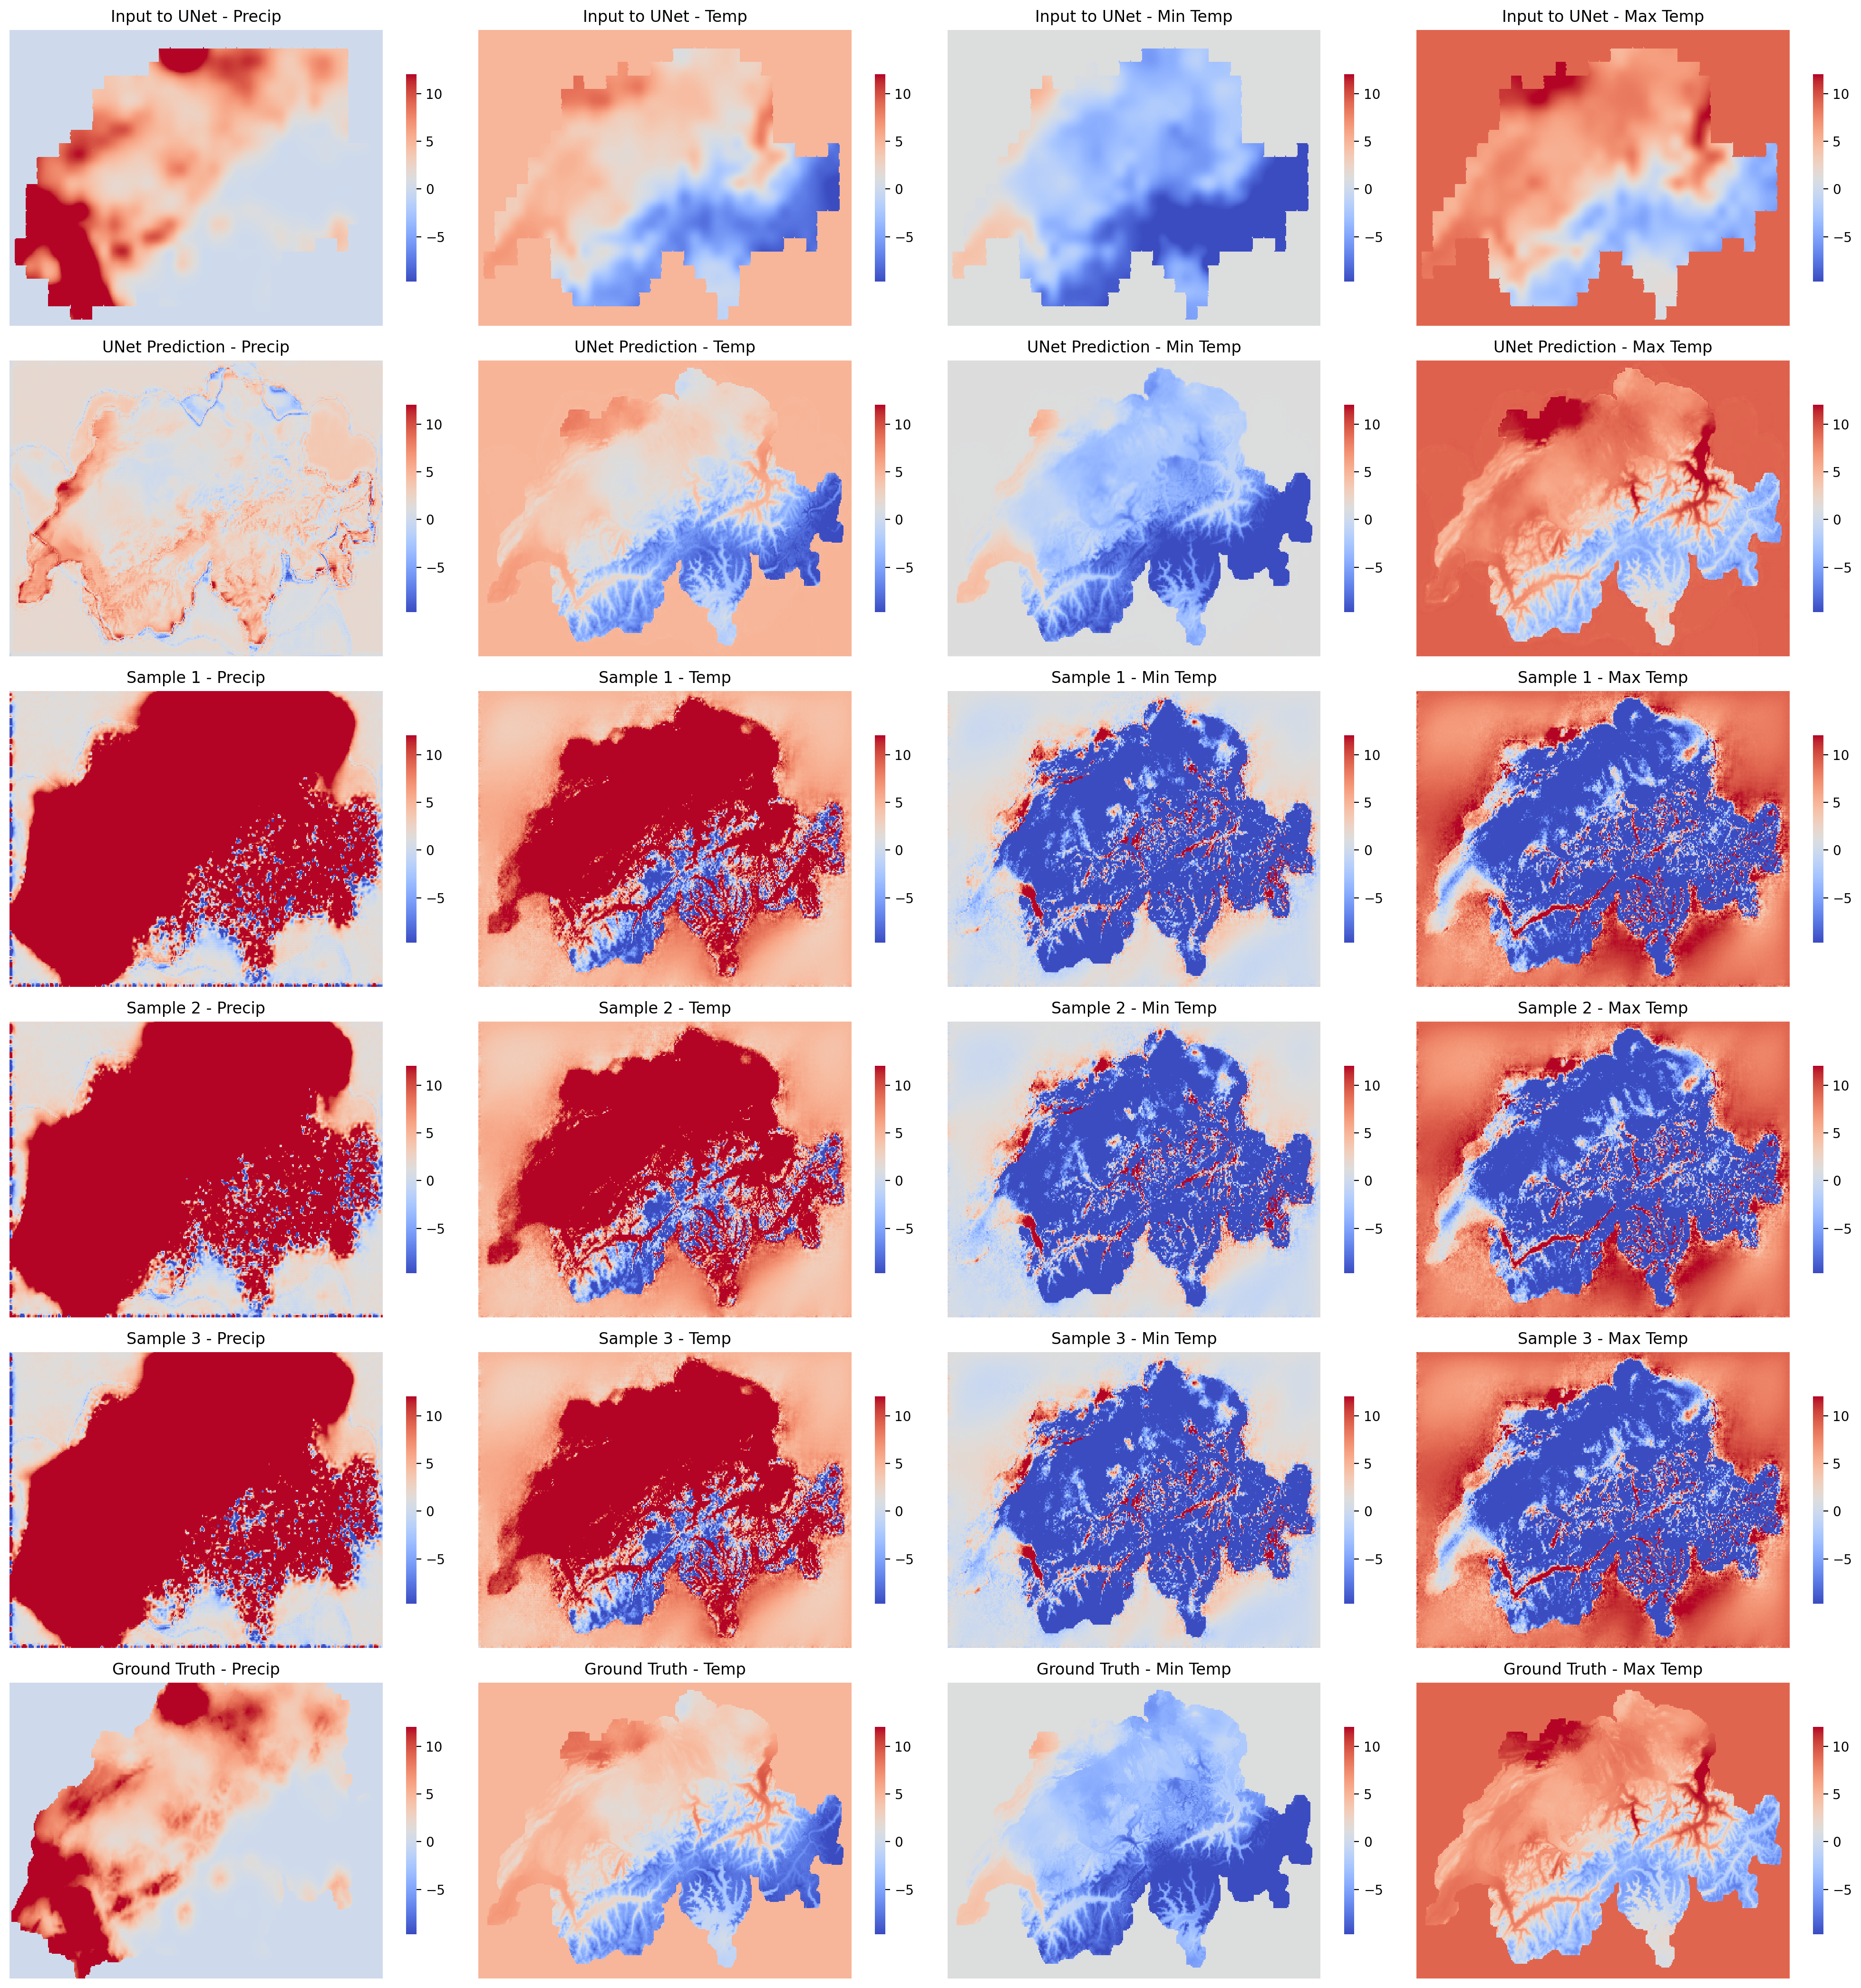

In [24]:
denorm_plot_samples(results_list, input_sample, target_sample)